# Machine Learning Model


The aim of this notebook will be to implement different models and analyze their performance with different hyperparameters.

The model will be trained with pre-processed data that'll have categorical variables and no outliers.

The package will be sci-kit learn and the data set source: kaggle.com

#### Some conclusions from the exploratory data analysis:

 - Children of age between 0 - 10 years were the most likely to survive. This group almost perfectly mixed between males and females.
 - It was noticed that even though there were more males in the boat, more females survived as a result of priorities when using safety boats.
 - People with 1st class tickets where the most likely to survive with a 50% chance, whereas 3rd class were the less likely with a chances of only 24%, it was also the class with more people.
 - Outliers for Age and Fare were slightly removed reducing the number of possible training entries to 762.
 - Embarked, Pclass, Sex and Survived were changed to categorical variables.
 - Embarked port doesn't seem to have and impact on whether a passenger survived or not. As it presents the same distribution.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn import metrics

df = pd.read_pickle('./train_processed.pkl')
df.head(10)

,Survived,Sex,Age,SibSp,Parch,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,-0.461538,1.0,0.0,0,0,1,0,0,1
1,1,0,0.769231,1.0,0.0,1,0,0,1,0,0
2,1,0,-0.153846,0.0,0.0,0,0,1,0,0,1
3,1,0,0.538462,1.0,0.0,0,0,1,1,0,0
4,0,1,0.538462,0.0,0.0,0,0,1,0,0,1
5,0,1,0.000000,0.0,0.0,0,1,0,0,0,1
6,0,1,2.000000,0.0,0.0,0,0,1,1,0,0
7,0,1,-2.000000,3.0,1.0,0,0,1,0,0,1
8,1,0,-0.076923,0.0,2.0,0,0,1,0,0,1
9,1,0,-1.076923,1.0,0.0,1,0,0,0,1,0


In [85]:
# Split Testing and training data
independent_variables = df.drop(columns=['Survived', 'SibSp'])
dependent_variable = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(independent_variables, dependent_variable, test_size=.2)

X_train.shape

(712, 9)

## Remove Outliers

In [86]:
numerical_variables = ['Age', 'Parch']

def outliers_col():
    for column in numerical_variables:
        n_outliers = len(X_train[np.abs(stats.zscore(X_train[column])) >= 3])    
        print("{} | {} | {}".format(
            X_train[column].name,
            n_outliers,
            X_train[column].dtype
        ))
outliers_col()

Age | 6 | float64
Parch | 11 | float64


In [88]:
for column in numerical_variables:
    y_train = y_train.drop(X_train[np.abs(stats.zscore(X_train[column])) > 3].index)
    X_train = X_train[np.abs(stats.zscore(X_train[column])) <= 3]
    
outliers_col()

Age | 0 | float64
Parch | 0 | float64


In [89]:
y_train.shape

(694,)

# Modelling

## Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Distributions to randomize
distributions = dict(C=uniform(loc=0, scale=5),
                      penalty=['l2', 'l1'])


clf_logistic = RandomizedSearchCV(LogisticRegression(solver='saga',max_iter=1000), distributions,cv=10)
clf_logistic.fit(X_train, y_train)

print(clf_logistic.best_params_)
clf_logistic.score(X_train, y_train)

{'C': 4.024081036285339, 'penalty': 'l2'}


0.7881844380403458

## Multi-layer Perceptron (ANN)

In [92]:
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint

distributions = dict(alpha=uniform(loc=0, scale=5), activation=['logistic', 'relu'], 
                     hidden_layer_sizes=randint(60, 150 + 1))

clf_ANN = RandomizedSearchCV(MLPClassifier(max_iter=2000), distributions, random_state=42, cv=10)
search_mlp = clf_ANN.fit(X_train, y_train)
print(search_mlp.best_params_)

clf_ANN.score(X_train, y_train)

{'activation': 'relu', 'alpha': 0.9091248360355031, 'hidden_layer_sizes': 80}


0.8184438040345822

## Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

distributions = dict(max_features=['auto', 'sqrt', 'log2'], n_estimators=randint(80, 150), min_samples_split=randint(2, 20))
clf_rf = RandomizedSearchCV(RandomForestClassifier(), distributions, cv=10)

clf_rf.fit(X_train, y_train)
print(clf_rf.best_params_)
clf_rf.score(X_train, y_train)

{'max_features': 'auto', 'min_samples_split': 16, 'n_estimators': 96}


0.8515850144092219

# Evaluation

In [101]:
test = RandomForestClassifier(max_features='log2', min_samples_split=5, n_estimators=100)
test.fit(X_train, y_train)

test.score(X_test, y_test)

0.8100558659217877

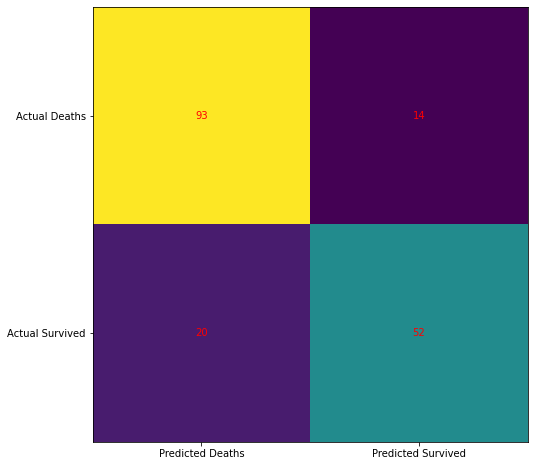

In [107]:
cm = confusion_matrix(y_test, test.predict(X=X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Deaths', 'Predicted Survived'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Deaths', 'Actual Survived'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()